In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env HF_TOKEN=your_huggingface_token_here
%env OPENROUTER_API_KEY=your_openrouter_api_key_here


env: HF_TOKEN=your_huggingface_token_here
env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [2]:
from datasets import load_dataset

# Remove problematic arguments; just use default config and let datasets handle cache
downloaded_dataset = load_dataset('profoz/airbnb-policy-scenarios')
downloaded_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'situation', 'solution', 'document_id', 'article'],
        num_rows: 809
    })
    test: Dataset({
        features: ['url', 'situation', 'solution', 'document_id', 'article'],
        num_rows: 232
    })
})

In [3]:
downloaded_dataset['test'][0]

{'url': 'https://www.airbnb.com',
 'situation': 'A traveler is interested in renting a cottage for a month in the Outer Banks and wants to know if Airbnb offers this type of rental and how to find it.',
 'solution': "According to the article, Airbnb offers a variety of rental types, including cottage rentals, and specifically lists 'Outer Banks Cottage rentals' among its popular categories. Therefore, the traveler can search for 'Outer Banks Cottage rentals' on the Airbnb website to find available options for a monthly stay (Source: Airbnb article content, 'Outer Banks Cottage rentals').",
 'document_id': 0,
 'article': "\nAirbnb: Vacation Rentals, Cabins, Beach Houses, Unique Homes & ExperiencesSkip to contentWe’re sorry, some parts of the Airbnb website don’t work properly without JavaScript enabled.Airbnb homepageHomesHomesNEWNEWExperiencesExperiences, newNEWNEWServicesServices, newWhereCheck inAdd datesCheck outAdd datesWhoAdd guestsBecome a hostHelp CenterBecome a hostIt's easy to

In [4]:
from ai.agent import PolicyAgent

model_name = "openai/gpt-4.1"

db_agent = PolicyAgent(
    model_name=model_name,
    company_name="Airbnb",
    
    enable_database_search=True,
    documents=downloaded_dataset['test']['article'],

    additional_system_prompt="ALWAYS USE the BM25 tool before answering any question, even if you think you don't need it. Attempt to find a relevent article before answering the question."
    
    )

db_agent_no_prompt = PolicyAgent(
    model_name=model_name,
    company_name="Airbnb",
    
    enable_database_search=True,
    documents=downloaded_dataset['test']['article']
    )

no_db_agent = PolicyAgent(
    model_name=model_name,
    company_name="Airbnb",
    enable_database_search=False
)

agents = {
    "db_agent_with_prompt": db_agent,
    "no_db_agent": no_db_agent,
    "db_agent_no_prompt": db_agent_no_prompt
}

In [5]:
from ai.rubric import get_structured_scorer

sample_ai_response = agents['db_agent_with_prompt'].ask_question(
    downloaded_dataset['test'][0]['situation'],
    include_tool_calls=True
)

score_ai_response = get_structured_scorer(model_name="meta-llama/llama-4-scout")

rubric_result = score_ai_response(
    question=downloaded_dataset['test'][0]['situation'],
    ai_response=sample_ai_response['response'],
    ground_truth=downloaded_dataset['test'][0]['solution']
)

In [7]:
print("Rubric Results")
print('='*50)

print(f'Reasoning: {rubric_result.reasoning}')
print('='*50)
print(f'Score: {rubric_result.score}')
print('='*50)

Rubric Results
Reasoning: The AI response confirms that Airbnb offers monthly cottage rentals in the Outer Banks and provides a detailed step-by-step guide on how to find such rentals. This matches the ground truth information that Airbnb offers cottage rentals in the Outer Banks and lists 'Outer Banks Cottage rentals' as a popular category. The AI response also accurately describes the search process, including setting the destination to 'Outer Banks', adjusting the dates for a month, and using filters for 'Cottage' and 'Monthly Rentals'. The response includes additional practical steps and references to Airbnb's policies, which align with the ground truth. There are no major errors or omissions in the response.
Score: 3


In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Run rubric over all dataset and collect results
rows = []

In [26]:
# Add tqdm progress bar for the outer loop
# If rows already has items, skip those examples/agents
existing_keys = set()
for row in rows:
    # Use a tuple of (question, agent) as a unique key
    existing_keys.add((row["question"], row["agent"]))

for example in tqdm(downloaded_dataset['test'], desc="Evaluating test examples"):
    for agent_name, agent_instance in agents.items():
        question = example['situation']
        ground_truth = example['solution']
        key = (question, agent_name)
        if key in existing_keys:
            continue  # Skip if already processed
        ai_response = agent_instance.ask_question(question, include_tool_calls=True)
        try:
            result = score_ai_response(
                question=question,
                ai_response=ai_response['response'],
                ground_truth=ground_truth
            )
        except:
            continue
        rows.append({
            "score": result.score,
            "reasoning": result.reasoning,
            "question": question,
            "ai_response": ai_response['response'],
            "ground_truth": ground_truth,
            "tool_calls": ai_response['tool_calls'],
            "agent": agent_name
        })

Evaluating test examples: 100%|██████████| 232/232 [31:05<00:00,  8.04s/it]


In [27]:
import pandas as pd

# Create a DataFrame from rows
df = pd.DataFrame(rows)
df['num_tool_calls'] = df['tool_calls'].apply(len)
df.to_csv(f'agent_prompting_test_{model_name.replace("/", "_")}.csv', index=False)

df.head()

,score,reasoning,question,ai_response,ground_truth,tool_calls,agent,num_tool_calls
0,3,The AI response confirms that Airbnb offers mo...,A traveler is interested in renting a cottage ...,"Yes, Airbnb does offer monthly cottage rentals...","According to the article, Airbnb offers a vari...","[{'tool_name': 'bm25_database_search', 'tool_a...",db_agent_with_prompt,1
1,3,The AI response provides a comprehensive guide...,A traveler is interested in renting a cottage ...,"**Brief Answer:** \nYes, Airbnb offers monthl...","According to the article, Airbnb offers a vari...",[],no_db_agent,0
2,3,The AI response provides accurate information ...,A traveler is interested in renting a cottage ...,"Yes, Airbnb does offer monthly cottage rentals...","According to the article, Airbnb offers a vari...",[],db_agent_no_prompt,0
3,2,The AI response provides detailed information ...,A guest is concerned about a neighborhood issu...,You can report a neighborhood issue related to...,"According to the Airbnb Help Center, there is ...","[{'tool_name': 'bm25_database_search', 'tool_a...",db_agent_with_prompt,1
4,2,The AI response provides detailed steps on how...,A guest is concerned about a neighborhood issu...,You can report neighborhood concerns to Airbnb...,"According to the Airbnb Help Center, there is ...",[],no_db_agent,0


In [1]:
import pandas as pd
model_name = 'openai/gpt-4.1'
df = pd.read_csv(f'agent_prompting_test_{model_name.replace("/", "_")}.csv')

df.shape

(696, 8)

In [2]:
import pandas as pd
model_name = 'openai/gpt-4.1'
loaded_df = pd.read_csv(f'agent_prompting_test_{model_name.replace("/", "_")}.csv')

In [7]:
loaded_df.groupby('agent')['score'].value_counts(normalize=True)

agent                 score
db_agent_no_prompt    2        0.448276
                      3        0.443966
                      1        0.068966
                      0        0.038793
db_agent_with_prompt  3        0.706897
                      2        0.224138
                      0        0.056034
                      1        0.012931
no_db_agent           3        0.478448
                      2        0.413793
                      1        0.081897
                      0        0.025862
Name: proportion, dtype: float64

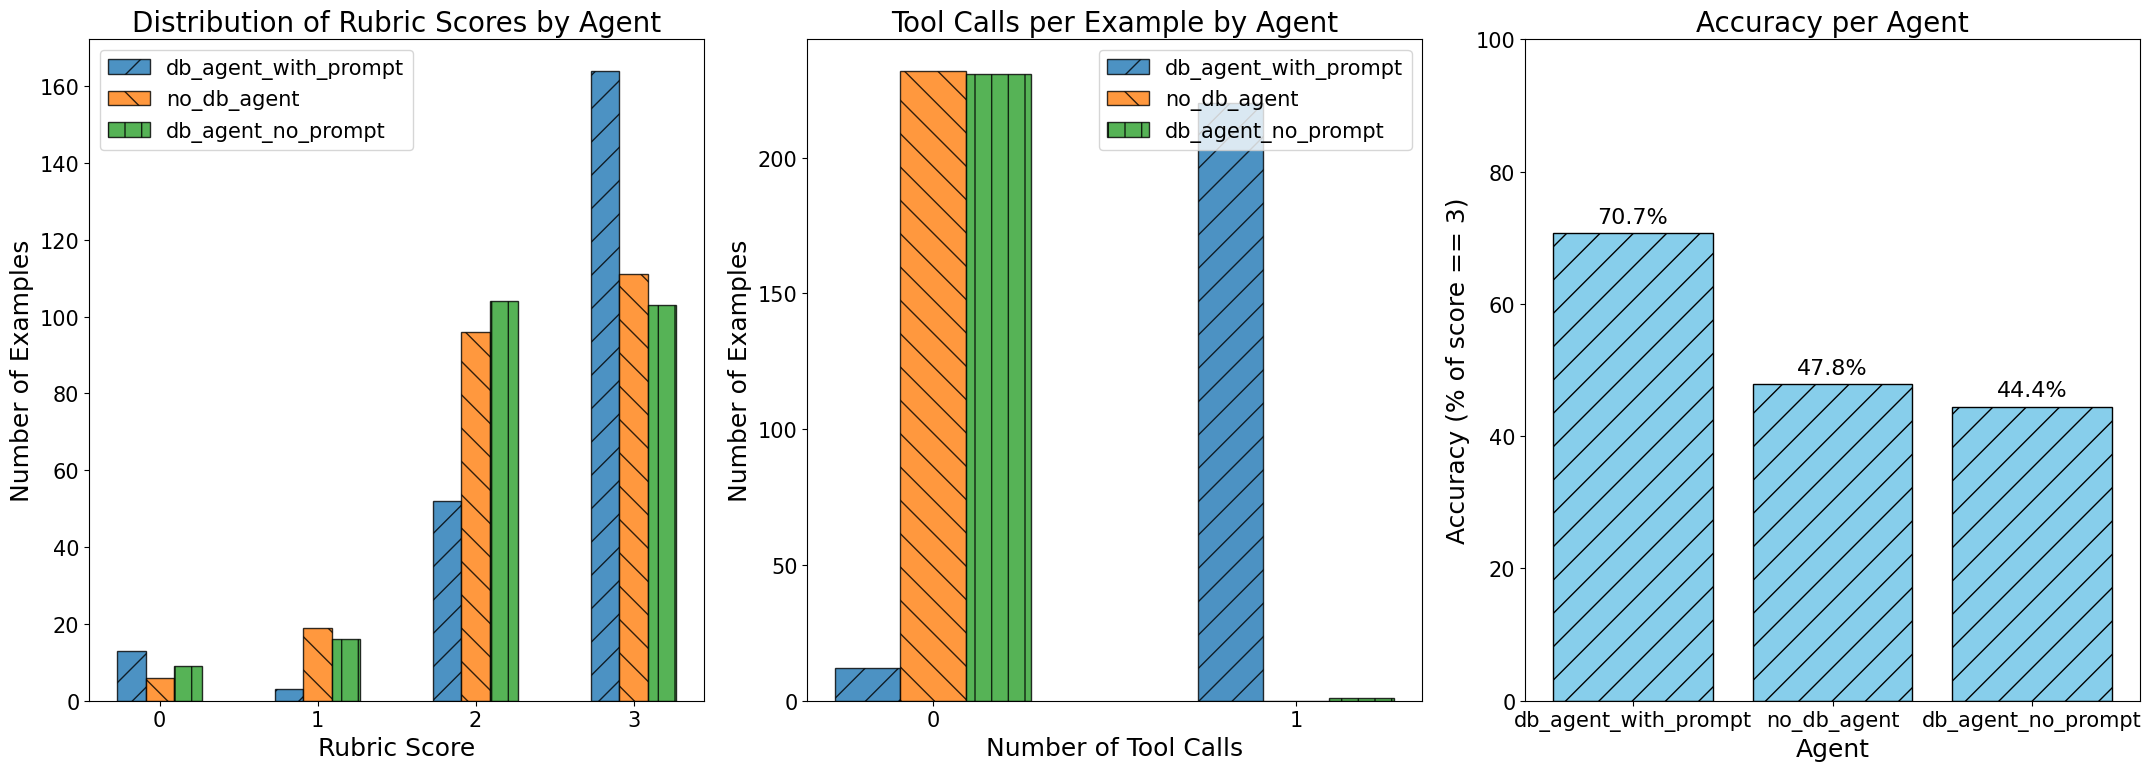

In [2]:
# Plot all three graphs in a single figure with subplots for easier comparison
import matplotlib.pyplot as plt
import numpy as np

hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
agent_names = list(df['agent'].unique())
num_agents = len(agent_names)

# Set font sizes for the entire plot
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})

fig, axs = plt.subplots(1, 3, figsize=(22, 8))

# 1. Distribution of Rubric Scores by Agent
score_bins = [-0.5, 0.5, 1.5, 2.5, 3.5]
bar_width = 0.18
x = np.array([0, 1, 2, 3])
for i, agent_name in enumerate(agent_names):
    agent_scores = df[df['agent'] == agent_name]['score']
    counts, _ = np.histogram(agent_scores, bins=score_bins)
    axs[0].bar(x + i*bar_width - (num_agents-1)*bar_width/2, counts, 
               width=bar_width, 
               label=agent_name, 
               alpha=0.8, 
               edgecolor='black', 
               hatch=hatch_patterns[i % len(hatch_patterns)])
axs[0].set_xticks(x)
axs[0].set_xlabel('Rubric Score', fontsize=18)
axs[0].set_ylabel('Number of Examples', fontsize=18)
axs[0].set_title('Distribution of Rubric Scores by Agent', fontsize=20)
axs[0].legend(fontsize=15)

# 2. Distribution of Number of Tool Calls by Agent
max_tool_calls = df['num_tool_calls'].max()
tool_call_bins = np.arange(0, max_tool_calls+2) - 0.5
x_tool = np.arange(0, max_tool_calls+1)
for i, agent_name in enumerate(agent_names):
    agent_tool_calls = df[df['agent'] == agent_name]['num_tool_calls']
    counts, _ = np.histogram(agent_tool_calls, bins=tool_call_bins)
    axs[1].bar(x_tool + i*bar_width - (num_agents-1)*bar_width/2, counts, 
               width=bar_width, 
               label=agent_name, 
               alpha=0.8, 
               edgecolor='black', 
               hatch=hatch_patterns[i % len(hatch_patterns)])
axs[1].set_xticks(x_tool)
axs[1].set_xlabel('Number of Tool Calls', fontsize=18)
axs[1].set_ylabel('Number of Examples', fontsize=18)
axs[1].set_title('Tool Calls per Example by Agent', fontsize=20)
axs[1].legend(fontsize=15)

# 3. Accuracy per Agent (% of score == 3)
accuracy_per_agent = []
for agent_name in agent_names:
    agent_df = df[df['agent'] == agent_name]
    total = len(agent_df)
    num_3 = (agent_df['score'] == 3).sum()
    accuracy = 100 * num_3 / total if total > 0 else 0
    accuracy_per_agent.append(accuracy)
bars = axs[2].bar(agent_names, accuracy_per_agent, color='skyblue', edgecolor='black', hatch='/')
axs[2].set_ylabel('Accuracy (% of score == 3)', fontsize=18)
axs[2].set_xlabel('Agent', fontsize=18)
axs[2].set_title('Accuracy per Agent', fontsize=20)
axs[2].set_ylim(0, 100)
for bar, acc in zip(bars, accuracy_per_agent):
    axs[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{acc:.1f}%", 
                ha='center', va='bottom', fontsize=16)

plt.tight_layout()
plt.savefig(f'agent_prompt_test_tool_calls_vs_accuracy_{model_name.replace("/", "_")}.png', dpi=300)
plt.show()

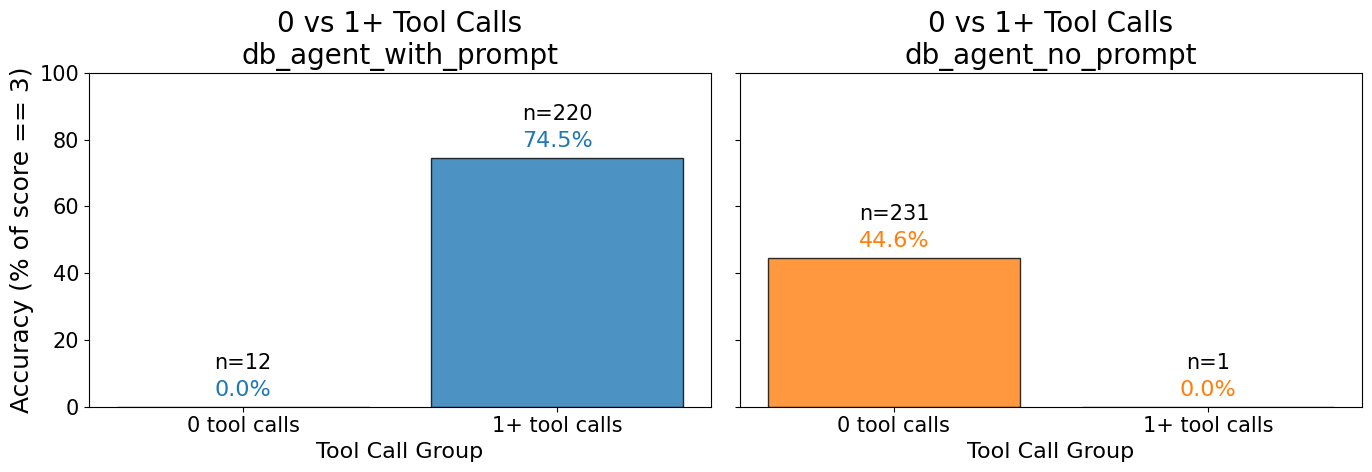

In [3]:
# Show accuracy for 0 tool calls vs 1+ tool calls for both 'db_agent_with_prompt' and 'db_agent_no_prompt'
# Also add label for count

import matplotlib.pyplot as plt
import numpy as np

agents_to_plot = ['db_agent_with_prompt', 'db_agent_no_prompt']
colors = ['tab:blue', 'tab:orange']
bar_colors = ['tab:gray', 'tab:brown']

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for idx, agent_name in enumerate(agents_to_plot):
    agent_df = df[df['agent'] == agent_name]

    # Split into 0 tool calls and 1+ tool calls
    zero_tool = agent_df[agent_df['num_tool_calls'] == 0]
    oneplus_tool = agent_df[agent_df['num_tool_calls'] >= 1]

    # Compute accuracy and count for each group
    groups = [
        ('0 tool calls', zero_tool),
        ('1+ tool calls', oneplus_tool)
    ]
    labels = []
    accuracies = []
    counts = []

    for label, group in groups:
        total = len(group)
        num_3 = (group['score'] == 3).sum()
        accuracy = 100 * num_3 / total if total > 0 else 0
        labels.append(label)
        accuracies.append(accuracy)
        counts.append(total)

    ax = axes[idx]
    color = colors[idx]
    bar_color = bar_colors[idx]
    bars = ax.bar(labels, accuracies, color=color, edgecolor='black', alpha=0.8)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Accuracy (% of score == 3)' if idx == 0 else "", fontsize=18)
    ax.set_title(f'0 vs 1+ Tool Calls\n{agent_name}', fontsize=20)
    ax.set_xlabel('Tool Call Group', fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    # Add accuracy and count labels above bars
    for i, (bar, acc, count) in enumerate(zip(bars, accuracies, counts)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{acc:.1f}%", 
                ha='center', va='bottom', fontsize=16, color=color)
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, f"n={count}", 
                ha='center', va='bottom', fontsize=15, color='black')

fig.tight_layout()
plt.savefig(f'agent_prompt_test_tool_calls_vs_accuracy_split_{model_name.replace("/", "_")}.png', dpi=300)
plt.show()


In [30]:
# what we want it, when it uses tool calls, it is more accurate.
# 4.1 seems to be very confident and never wanted to use the db lookup. Nano looked things up at least even when we didn't prompt it to